In [1]:
%pip install -q -U langchain_openai langchain_core langgraph

You should consider upgrading via the '/Users/ron/Documents/github/myenv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Agent

In this notebook, **we're going to build a simple agent using using LangGraph**.

This notebook is part of the <a href="https://www.hf.co/learn/agents-course">Hugging Face Agents Course</a>, a free course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

As seen in the Unit 1, an agent needs 3 steps as introduced in the ReAct architecture :
[ReAct](https://react-lm.github.io/), a general agent architecture.

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)


![Agent](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Agent.png)

In [4]:
import os
from dotenv import load_dotenv

In [5]:
# Load the .env file
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

In [6]:
import base64
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

vision_llm = ChatOpenAI(model="gpt-4o")


def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """
    all_text = ""
    try:

        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # You can choose whether to raise or just return an empty string / error message
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""


llm = ChatOpenAI(model="gpt-4o")


def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b


tools = [
    divide,
    extract_text
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

/Users/ron/Documents/github/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The input document
    input_file: Optional[str]  # Contains file path, type (PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [8]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool


def assistant(state: AgentState):
    # System message
    textual_description_of_tool = """
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image = state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some computation without provided tools :\n{textual_description_of_tool} \n You have access to some optional images. Currently the loaded images is : {image}")

    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])], "input_file": state["input_file"]}

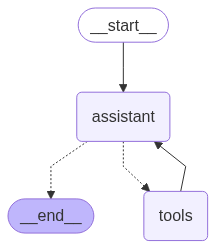

In [9]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

 Let's create our LLM and prompt it with the overall desired agent behavior.

We define a `tools` node with our list of tools.

The `assistant` node is just our model with bound tools.

We create a graph with `assistant` and `tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `tools` based on  whether the `assistant` calls a tool.

Now, we add one new step:

We connect the `tools` node *back* to the `assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

In [10]:
messages = [HumanMessage(content="Divide 6790 by 5")]
messages = react_graph.invoke({"messages": messages, "input_file": None})

In [11]:
messages

{'input_file': None,
 'messages': [HumanMessage(content='Divide 6790 by 5', additional_kwargs={}, response_metadata={}, id='79bfc929-2a9c-4545-ae45-87f1fdceb3f9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_iU2vUutPtfpz95xvJCrAdbe4', 'function': {'arguments': '{"a":6790,"b":5}', 'name': 'divide'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 195, 'total_tokens': 213, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-ByuEi1kao9W0M1oGAhyppTOUZpeWm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--56fb5d0c-c775-4064-b922-6d9d028d6c61-0', tool_calls=[{'name': 'divide', 'args': {'a': 6790, 'b': 5}, 'id': 'call_iU2

In [12]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_iU2vUutPtfpz95xvJCrAdbe4)
 Call ID: call_iU2vUutPtfpz95xvJCrAdbe4
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

6790 divided by 5 equals 1358.0.


## Training program
MR Wayne left a note with his training program for the week. I came up with a recipe for dinner left in a note.

you can find the document [HERE](https://huggingface.co/datasets/agents-course/course-images/blob/main/en/unit2/LangGraph/Batman_training_and_meals.png), so download it and upload it in the local folder.

![Training](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png)

In [13]:
!PWD

/Users/ron/Documents/github/AI_Agents_HF/LangGraph


In [14]:
!ls

Batman_training_and_meals.png Joker_1.png
cryptobro.png                 LangGraph_agent.ipynb
Email_sorting.ipynb


In [15]:
messages = [HumanMessage(content="According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?")]

messages = react_graph.invoke({"messages": messages, "input_file": "Batman_training_and_meals.png"})

In [16]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_iqokYMXMhE0NRfFMlYDAMfIW)
 Call ID: call_iqokYMXMhE0NRfFMlYDAMfIW
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE   
For the week of 2/20-2/26   

SUNDAY 2/20   
MORNING   
30 minute jog   
30 minute meditation   

EVENING   
clean and jerk lifts—3 reps/8 sets. 262 lbs.   
5 sets metabolic conditioning:   

5 snatches    
12 kettlebell swings   
12 pull-ups   
10 minutes flexibility   
30 minutes sparring   

MONDAY 2/21   
MORNING   
30 minute jog   
30 minutes traditional kata (focus on Japanese forms)   

EVENING   
5 sets 20 foot rope climb   
30 

In [17]:
messages = [HumanMessage(content="According to the training schedule for MR wayne in the provided images. Calculate the calory burnt per day due to the training? Also break down the calory burnt per work out")]
messages = react_graph.invoke({"messages": messages, "input_file": "Batman_training_and_meals.png"})

In [18]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According to the training schedule for MR wayne in the provided images. Calculate the calory burnt per day due to the training? Also break down the calory burnt per work out
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_FYZRCIc1otPm8RLgycigWUZH)
 Call ID: call_FYZRCIc1otPm8RLgycigWUZH
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE  
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
30 minute jog
30 minute meditation
EVENING
clean and jerk lifts—3 reps/8 sets. 262 lbs.
5 sets metabolic conditioning:
5 mile run
12 kettlebell swings
12 pull-ups
30 minutes flexibility
30 minutes sparring

MONDAY 2/21
MORNING
30 minute jog
30 minutes traditional kata (focus on Japanese forms)
EVENING
5 sets 20 foot rope climb
30 minutes gymn

In [19]:
messages = [HumanMessage(content="According to the training schedule for MR wayne in the provided images. Suggest an French lunch menu to support the intensive training schedule.")]
messages = react_graph.invoke({"messages": messages, "input_file": "Batman_training_and_meals.png"})

In [20]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According to the training schedule for MR wayne in the provided images. Suggest an French lunch menu to support the intensive training schedule.
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_rPxhuTLgZptouibzN077cG8L)
 Call ID: call_rPxhuTLgZptouibzN077cG8L
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
30 minute jog
30 minute meditation
EVENING
clean and jerk lifts-3 reps/8 sets. 262 lbs.
5 sets metabolic conditioning:
	1 mile run	
	22 kettlebell swings
	12 pull-ups
	30 minutes flexibility
	30 minutes sparring

MONDAY 2/21
MORNING
30 minute jog
30 minutes traditional kata (focus on Japanese forms)
EVENING
5 sets 20 foot rope climb
30 minutes gymnastics (work on muscle up